<style>
@import url(https://www.numfys.net/static/css/nbstyle.css);
</style>
<a href="https://www.numfys.net"><img class="logo" /></a>

# Электрон-позитронная аннигиляция

### Examples - Particle and Nuclear Physics
<section class="post-meta">
By Jonas Tjemsland, Eilif Sommer Øyre and Jon Andreas Støvneng
</section>
Last edited: April 15th 2018 
___

На этом уроке мы обсудим рассеяние электронов на позитронах при $Z$-резонансе. В частности, мы будем использовать генератор событий для запуска моделирования Монте-Карло для процесса аннигиляции $e^++e^ - \to Z\to?$, а затем визуализируем результаты в виде энергетических спектров. Генератор событий позаботится о каскадировании и адронизации. На эту тему были проведены физические эксперименты. Электрон-позитронное рассеяние в Z-резонансе было изучено в рамках сотрудничества ALEPH на Большом электрон-позитронном коллайдере (LEP) в ЦЕРНЕ [1]. 

Будет использоваться генератор событий Pythia 8.2 [2, 3, 4]. Это стандартный инструмент для генерации высокоэнергетических столкновений, и считается точным для $>10\;\mathrm{GeV}$. Программа работает для коллизий адрон-адрон и лептон-лептон. Pythia 8 написана на C++, но существует оболочка для Python.

В дальнейшем мы всегда ссылаемся на Стандартную модель. Мы начинаем с импорта необходимых пакетов. Установка оболочки Python для Pythia описана в конце этой записной книжки. Установка Pythia содержит несколько примеров, с которыми вы можете поиграть.

In [ ]:
# Import Pythia
import sys
cfg = open("Makefile.inc")
lib = ""
for line in cfg:
    if line.startswith("PREFIX_LIB="): lib = line[11:-1]; break
sys.path.insert(0, lib)
import pythia8

# Import other packages
import numpy as np
import matplotlib.pyplot as plt
import progressbar
%matplotlib inline

In [2]:
# Set common figure parameters
fontSize = 14
newparams = {'figure.figsize': (15, 6),
             'font.size': fontSize, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral',
             'lines.linewidth': 2.0}
plt.rcParams.update(newparams)

# Set constants
me = 0.000511 # GeV. Electron mass
mp = 0.93827  # GeV. Proton mass
mZ = 91.1876  # GeV. Z mass

## Настройка процесса, $e^+ + e^- \rightarrow Z \rightarrow ?$

#### Настройки

Мы будем моделировать рассеяние позитрона и электрона. То есть мы столкнем позитрон и электрон с некоторой энергией центра масс $E_\mathrm{CM}$ и посмотрим, какие частицы образуются после адронизации и каскадов.

Нам нужно определить `Pythia`-объект, который будет обрабатывать моделирование процесса.

In [3]:
# Initialise a pythia object
pythia = pythia8.Pythia()

Настройки генератора событий можно сохранить в файле и загрузить с помощью `pythia.ReadFile()`. Однако здесь мы будем использовать `pythia.ReadString()` для чтения отдельных настроек.

Значение энергии центра масс называется `Beams:eCM` и задается в единицах $\mathrm{ГэВ}$. Мы выбираем, чтобы частицы сталкивались в $Z$-резонансе, $E_\mathrm{CM}=91.1876\;\mathrm{GeV}$.

Исходные частицы определяются с помощью настроек `Beams:idA` и `Beams:idB`, и рассчитываются с помощью [Схемы Нумерации Частиц Монте-Карло](http://pdg.lbl.gov/2017/reviews/rpp2017-rev-monte-carlo-numbering.pdf) [5]. В этой схеме каждой частице присваивается целое число. Частицам присваиваются положительные числа, а античастицам - отрицательные. Некоторые значения приведены в таблице ниже (полный список и подробные сведения о схеме см. в [5]).

<center> Таблица 1. Список некоторых элементарных частиц и их нумерация частиц по методу Монте-Карло [5]

| Quarks |    | Leptons    |    | Gauge Bosons |    | Hadrons |      |
|:------:|:--:|:----------:|:--:|:------------:|:--:|:-------:|:----:|
| $d$    | 1  | $e^-$      | 11 | $\gamma$     | 22 | $p$     | 2212 |
| $u$    | 2  | $\nu_e$    | 12 | $Z^0$        | 23 | $n$     | 2112 |
| $s$    | 3  | $\mu^-$    | 13 | $W^+$        | 24 | $\pi^0$ | 111  |
| $c$    | 4  | $\nu_\mu$  | 14 | $h^0$        | 25 | $\pi^+$ | 211  |
| $b$    | 5  | $\tau^-$   | 15 |              |    | $K^0_L$ | 130  |
| $t$    | 6  | $\nu_\tau$ | 16 |              |    | $K^+$   | 321  |

In [4]:
# Set collision properties
pythia.readString("Beams:idA = 11")
pythia.readString("Beams:idB = -11")
pythia.readString("Beams:eCM = 91.1876");

В Pythia частицы с (номинальным) временем жизни $\tau_0 < 10^3\;\mathrm{mm/}c$ распадаются по умолчанию. Однако мы будем рассматривать только стабильные частицы. Таким образом, мы позволяем даже долгоживущим частицам $\mu^{\pm}$, $\pi^\pm$, $K^\pm$, $K^0_L$ и $n$ распадаться. Это достигается с помощью настройки `???:mayDecay`. Нейтроны $n$, например, имеют время жизни $\tau= 880\;\mathrm{s}\approx 3\times10^8\;\mathrm{km}/c$, и они в большинстве приложений могут рассматриваться как стабильные. Однако, когда нейтроны имеют происхождение от астрочастиц, они распадутся, не достигнув Земли.

In [5]:
pythia.readString("13:mayDecay   = true")
pythia.readString("211:mayDecay  = true")
pythia.readString("321:mayDecay  = true")
pythia.readString("130:mayDecay  = true")
pythia.readString("2112:mayDecay = true");

#### Возможные процессы и взаимодействия

Наконец, нам нужно выбрать, какие процессы включить. В природе существуют четыре фундаментальные силы, показанные в таблице 2.

<br></br>
<center> Таблица 2. Четыре фундаментальные силы (взяты из [6]).</center>
    
| Взаимодействие | Порядок величины | Теория | Посредник |
|:-----:|:--------:|:------:|:--------:|
| Сильное | 10 | Хромодинамика | Глюон, $g$ |
| Электромагнитное | $10^{-2}$ | Электродинамика | Фотон, $\gamma$ |
| Слабое | $10^{-13}$ | Ароматодинамика | $W^\pm$ и $Z$ |
| Гравитационное | $10^{-42}$ | Геометродинамика | Гравитон |
<br>

Начальное состояние $e^+ + e^-$ нейтрально к заряду. Таким образом, электрон и позитрон могут распадаться на промежуточный фотон (электромагнетизм) или промежуточный $Z$ бозон (слабое взаимодействие) (мы пренебрегаем связью с Хиггсом). Соответствующие фундаментальные вершины показаны на рисунке 2. Более полный список вершин в квантовой электродинамике (QED), квантовой хромодинамике (QCD) и теории электрослабого взаимодействия (GWS) приведен в конце этого урока.

<br>
![Possible fundamental vertices](images/vertices_z_gamma.png)
**Рисунок 1.** *Диаграмы для электрослабого взаимодействия с нейтральным зарядом.*

Обратите внимание, что процессы, показанные на рисунке 1, не могут быть физическими из-за сохранения импульса. Чтобы получить физический процесс, две или более таких диаграм должны быть объединены в соответствии с набором правил (например, сохранение заряда и числа барионов для всех взаимодействий и сохранение цвета при электромагнитных и слабых взаимодействиях; см. [6] для получения дополнительной информации и более глубокого понимания). Это известно как диаграмма Фейнмана. Все взаимодействия элементарных частиц могут быть описаны таким образом. Обратите внимание, что промежуточные $\gamma$ и $Z$ являются виртуальными частицами, что означает, что их нельзя наблюдать напрямую.

Каждая вершина взаимодействия вносит вклад с коэффициентом $\propto \lambda$ в конечную амплитуду. Предполагается, что этот фактор, называемый константой связи, мал, так что проблему можно рассматривать как возмущение. То есть диаграммы с небольшим количеством вершин вносят наибольший вклад. В качестве примера рассмотрим процесс $e^++e^-\to e^++e^-$. Это известно как "рассеяние Бабхи". Диаграммы Фейнмана первого порядка для этого процесса показаны на рисунке 2 для фотона. 

![Babha scattering](images/bhabha.png)

**Рисунок 2** *Диаграммы Фейнмана первого порядка для рассеяния Бабхи. Верхняя диаграмма называется $t$-каналом, а $s$-канал показан внизу. Канал $u$ не отображается. Как выглядит $u$-канал?*

Теперь мы готовы выбрать, какие процессы включить. Полный список процессов и настроек, которым они соответствуют, показан в [Pythia 8.2](http://home.thep.lu.se/Pythia/pythia82html/ProcessSelection.html). Как мы видели, электрон и позитрон могут аннигилировать либо до $Z$ бозона, либо до фотона. То есть мы должны включить некоторые электрослабые процессы, которые приводят два фермиона либо к $Z$, либо к $\gamma$. Именно это и делает `WeakSingleBoson:ffbar2gmZ = on`. Обратите внимание, что фотонная ветвь будет подавлена при $Z$-резонансе, что мы и рассматриваем. Позже мы сможем проверить, так ли это на самом деле.

In [6]:
pythia.readString("WeakSingleBoson:ffbar2ffbar(s:gmZ) = on");
pythia.readString("WeakSingleBoson:all = on");

Наконец, мы инициализируем генератор событий.

In [7]:
pythia.init();

## Запуск моделирования

Теперь мы готовы запустить моделирование. Мы будем использовать $10^5$ событий для Монте-Карло. Это может быть немного чересчур для наших целей, но позже это даст плавные энергетические спектры. Класс pythia содержит все, что известно о текущем событии ($e^++e^-$ рассеяние). Он включает, например, начальные, промежуточные и конечные частицы, идентификатор частиц и четыре импульса частиц. Новое событие генерируется с помощью `pythia.next()`. Для каждого события мы перебираем все частицы, ищем заданный набор частиц ($\gamma$, $e^+$, $e^ -$, $p$ и $\bar p$) и храним энергию частицы в массиве, который позже будет использоваться для вычисления энергетического спектра.

**ПРИМЕЧАНИЕ:** При запуске моделирования Pythia печатает сообщения, используемые настройки и т.д. В терминале, в котором был запущен Jupyter. Эти сообщения можно отключить, а дополнительные включить. Проверьте их!

In [8]:
def run_simulations(pythia, IEvent):
def run_simulations(pythia, iEvent):
    # First element is mass
    eGamma = [0]
    eE = [0.000511]
    eN = [.93957 ]
    eP = [.93828]
    eNu = [0] # We treat the neutrinos as massless
    eRest = []

    w = [progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage(), ' ', progressbar.ETA()]
    bar = progressbar.ProgressBar(widgets=w)

    for i in bar(range(iEvent)):
        # Generate next event. Skip if fail
        if not pythia.next(): continue

        # Iterate through the particles in the event. For each final particle,
        # store the energy in an array
        for i in range(pythia.event.size()):
            if pythia.event[i].isFinal():
                idAbs = pythia.event[i].idAbs() # Absolute id
                eI = pythia.event[i].e()        # Energy
                if idAbs == 22:
                    # PHOTON
                    eGamma.append(eI)
                elif idAbs == 2212:
                    # PROTON
                    eP.append(eI)
                elif idAbs == 2112:
                    # NEUTRON
                    eN.append(eI)
                elif idAbs == 11:
                    # e+e-
                    eE.append(eI)
                elif idAbs == 12 or idAbs == 14 or idAbs == 16:
                    # NEUTRINOS
                    eNu.append(eI)
                else:
                    eRest.append(eI)
    return eGamma, eE, eN, eP, eNu, eRest

In [9]:
iEvent = 100000

In [10]:
eGamma, eE, eN, eP, eNu, eRest = run_simulations(pythia, iEvent)

[==========================================================] 100% Time: 0:02:32


## Энергетический Спектр

Окончательные результаты приведенного выше моделирования представляют собой набор массивов, содержащих энергии в ГэВ от конечных частиц в событиях. Результаты должны быть преобразованы таким образом, чтобы они стали независимыми от количества используемых событий. Обычный способ представления результата - это своего рода *энергетические спектры*, такие как
$$\frac{\mathrm{d}N}{\mathrm{d}E}\; [1/\mathrm{GeV}],\quad \text{or}\quad T\times \frac{\mathrm{d}N}{\mathrm{d}T} \; [1/\mathrm{GeV}],$$
где $N$ - плотность чисел, $E$ - энергия, а $T$ - кинетическая энергия. Мы будем использовать последнюю. Это достигается путем создания гистограммы данных и деления на количество событий и ширину ячейки гистограммы. Гистограмму можно создать с помощью `histrogram()` из `numpy`.

In [11]:
def get_hist(E, bins):
    """ Creates energy spectrum given an array of energies and the bins. """
    if len(E) < 2: return np.array([])
    bin_width = bins[1:] - bins[:-1]
    T = np.array(E[1:]) - E[0]
    y, bin_edges = np.histogram(T, bins=bins)
    return y/(iEvent*bin_width)

Давайте создадим гистограммы для результатов. Мы должны использовать логарифмически распределенные ячейки.

In [12]:
histNum = 100
bins = np.logspace(-5, 3, histNum)
bin_centers = 0.5*(bins[1:] + bins[:-1])

histGamma = get_hist(eGamma, bins)
histP = get_hist(eP, bins)
histNu = get_hist(eNu, bins)
histE = get_hist(eE, bins)
histN = get_hist(eN, bins)
if len(eRest) > 0:
    print("Additional particles were detected!")
else:
    print("All the different particles have been accounted for!")

All the different particles have been accounted for!


Теперь мы можем построить график результатов.

In [13]:
def plot_spectrum(bin_centers, histGamma, histP, histE, histNu):
    # Plot histograms loglog
    fig, ax = plt.subplots()

    if len(histGamma) > 0: ax.plot(bin_centers, bin_centers*histGamma, label=r"$\gamma$")
    if len(histP) > 0:     ax.plot(bin_centers, bin_centers*histP, label=r"$p\bar p$")
    if len(histE) > 0:     ax.plot(bin_centers, bin_centers*histE, label=r"$e^-e^+$")
    if len(histNu) > 0:    ax.plot(bin_centers, bin_centers*histNu, label=r"$\nu\bar\nu$")
    if len(histN) > 0:     ax.plot(bin_centers, bin_centers*histN, label=r"$n\bar n$")

    ax.set_xscale("log", nonposx='clip')
    ax.set_yscale("log", nonposy='clip')
    ax.legend(loc=2)
    plt.xlabel(r"$T$ [GeV]")
    plt.ylabel(r"Td$N$/d$T$")
    plt.show()

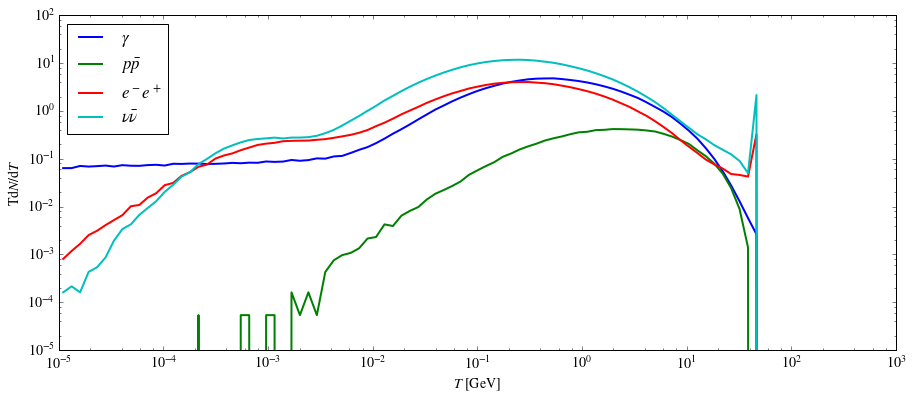

In [14]:
plot_spectrum(bin_centers, histGamma, histP, histE, histNu)

Обратите внимание, что все графики, за исключением безмассовых фотонов и легких нейтрино, сходят к нулю по мере уменьшения энергии. Это изменение происходит быстро. Более того, когда энергия увеличивается, энергетический спектр также уменьшается. Существует также внезапный пик в $~5\times 10^1\;\mathrm{ГэВ}$ для электронного и нейтринного спектра.

Давайте обсудим некоторые свойства форм графиков, в частности, почему энергетические спектры равны 0 для $T\gtrsim 50\;\mathrm{GeV}$.

### Протон и антипротон $p\bar p$

Энергетический спектр для протонов и антипротонов становится равным нулю при

In [15]:
print("T = %.2f GeV." % (np.max(eP) - mp))

T = 41.17 GeV.


Начальные частицы обладают энергией

$$E_i = 2m_e + E_\mathrm{CM} = 2\cdot 0.511\;\mathrm{MeV} + 91.1876\;\mathrm{GeV} \approx 91.2\;\mathrm{GeV}.$$

Протон и антипротон в состоянии покоя обладают энергией

$$E_f = 2m_p = 2\cdot 0.93827231 \;\mathrm{GeV} \approx 1.88 \;\mathrm{GeV}.$$

Если процессом будет $e^+ + e^- \to p + \bar p$, кинетическая энергия конечных частиц должна быть

$$T_p = T_\bar{p} = \frac{E_i - E_f}{2}=44.7 \;\mathrm{GeV}.$$

Таким образом, если мы увеличим число событий, мы увидим, что энергетический спектр протонов и антипротонов станет равным нулю при $E_{0, 2}\to 44.7\;\mathrm{GeV}.$

### Электрон и позитрон $e^-e^+$
Мы повторяем те же вычисления, что и выше:

In [16]:
print("T = %.5f GeV" % (np.max(eE)))
print("T = %.5f GeV (analytical)" % ((2*me + mZ - 2*me)/2))

T = 45.59380 GeV
T = 45.59380 GeV (analytical)


Обратите также внимание, что график для $e^-e^+$ расходится для $T~45.6\;\mathrm{GeV}$. Это соответствует процессу $e^+ + e^- \to Z \to e^+ + e^-$. Подробности выходят за рамки этого блокнота.

### Фотон и нейтрино, $\gamma$ и $\nu$

In [17]:
print("T = %.5f GeV" % (np.max(eGamma)))
print("T = %.5f GeV (analytical)" % ((2*me + mZ)/2))

T = 45.48929 GeV
T = 45.59431 GeV (analytical)


### Дальнейшая работа и упражнения

Поиграйте с введенным кодом и концепциями. Например, пусть долгоживущие частицы считаются стабильными, попробуйте с другими начальными частицами (не забудьте использовать правильные процессы) или попробуйте другие начальные энергии.

- Откуда берутся другие характеристики графиков, такие как пик при $\sim 45\;\mathrm{GeV}$ и максимальные значения?
- Пусть нейтрон будет стабильным. Почему энергетический спектр нейтрона и протона одинаков? *Подсказка. Закон сохранения.*
- Подробно изучите рассеяние Бабхи. Например, каково угловое распределение от Pythia? Что вы получаете на уровне дерева в QED (аналогичные вычисления приведены, например, в [5])?
- Электронно-позитронное рассеяние в Z-резонансе было изучено в сотрудничестве ALEPH на Большом электрон-позитронном коллайдере (LEP) в ЦЕРНЕ. 

### Ресурсы и дальнейшее чтение

[1] Check out the ALEPH website (http://aleph.web.cern.ch/) or the CERN website (https://home.cern/about/experiments/aleph)

[2] Sjostrand, Torbjorn et al.: A Brief Introduction to PYTHIA 8.1. Comput.Phys.Commun. 178 (2008) 852-867 [arXiv:0710.3820](https://arxiv.org/abs/0710.3820) [hep-ph] CERN-LCGAPP-2007-04, LU-TP-07-28, FERMILAB-PUB-07-512-CD-T  

[3] Sjostrand, Torbjorn et al.: PYTHIA 6.4 Physics and Manual. JHEP 0605 (2006) 026 hep-ph/0603175 FERMILAB-PUB-06-052-CD-T, LU-TP-06-13

[4] Pythia 8.2 online manual: http://home.thep.lu.se/Pythia/pythia82php/Welcome.php (accessed March 2018)

[5] C. Patrignani et al. (Particle Data Group), Chin. Phys. C, 40, 100001 (2016) and 2017 update.

[6] Griffiths, David J. 2008. Introduction to elementary particles. Second, revised edition. Wiley-vch.  

---
## Приложение

### Установка Pythia и настройка для Python

Скачайте [Pythia](http://home.thep.lu.se/~torbjorn/pythia8/pythia8230.tgz) и извлеките содержимое. В Linux вы можете использовать следующие команды терминала для извлечения Pythia в домашнюю папку:
```
cd ~
wget http://home.thep.lu.se/~torbjorn/pythia8/pythia8230.tgz
tar -xvf pythia8230.tgz
cd pythia8230
```
Настройте Python перед настройкой pythia.
```
./configure --with-python-include=/usr/include/python2.7 --with-python-bin=/usr/bin
```
Теперь настройте Pythia (см. http://home.thep.lu.se/Pythia/pythia82html/PythonInterface.html и http://home.thep.lu.se/Pythia/) запустив
```
make
```
Перейдите в папку, содержащую файл python, `cd /папка/содержащий/python/файл`. Затем скопируйте файл `Makefile.inc` с помощью
```
cp ~/pythia8230/examples/Makefile.inc .
```
Для получения дополнительной информации см. информационную страницу для [Python Interface](http://home.thep.lu.se/Pythia/pythia82html/PythonInterface.html).

### Некоторые Дополнительные Фундаментальные Вершины
Некоторые из фундаментальных вершин в электрослабой теории показаны на рисунке ниже. Фотон нейтрален по заряду и соединяется с двумя электрически заряженными частицами, такими как кварки или электрон. Бозон $Z$ также нейтрален по заряду и соединяется с любым лептоном. Бозоны $W^\pm$ заряжены и поэтому должны соединяться с двумя частицами с чистым зарядом. Это лептон и соответствующее нейтрино, $(l^-, \nu_l)$, или кварк и кварк с опозиционным вкусом, такие как кварк вверх и вниз. Таким образом, аромат кварков не сохраняется в электрослабой теории. Квантовая хромодинамика в этой тетради не обсуждается, но можно отметить, что глюон соединяется с любым кварком и что глюоны могут соединяться с другими глюонами в трех - или четырехвершинном пространстве, создавая так называемый глюонный шар. Глюоны также могут соединяться с фотонами.

![vertices](images/vertices.png)